In [38]:
#importing necessary libraries
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import datetime
from numpy import concatenate
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 22, 10

In [39]:
path="https://raw.githubusercontent.com/GeoTurkey/GMT_COURSES/main/ANKR_cod.trp"
df = pd.read_csv(path, sep=",", index_col="DateTime", parse_dates = True)
df=df.filter(["DateTime","ztd"])
df

,ztd
DateTime,
2003-06-08 00:00:00,2.13701
2003-06-08 02:00:00,2.13456
2003-06-08 04:00:00,2.12776
2003-06-08 06:00:00,2.13033
2003-06-08 08:00:00,2.11787
...,...
2020-12-31 16:00:00,2.13184
2020-12-31 18:00:00,2.13185
2020-12-31 20:00:00,2.12605


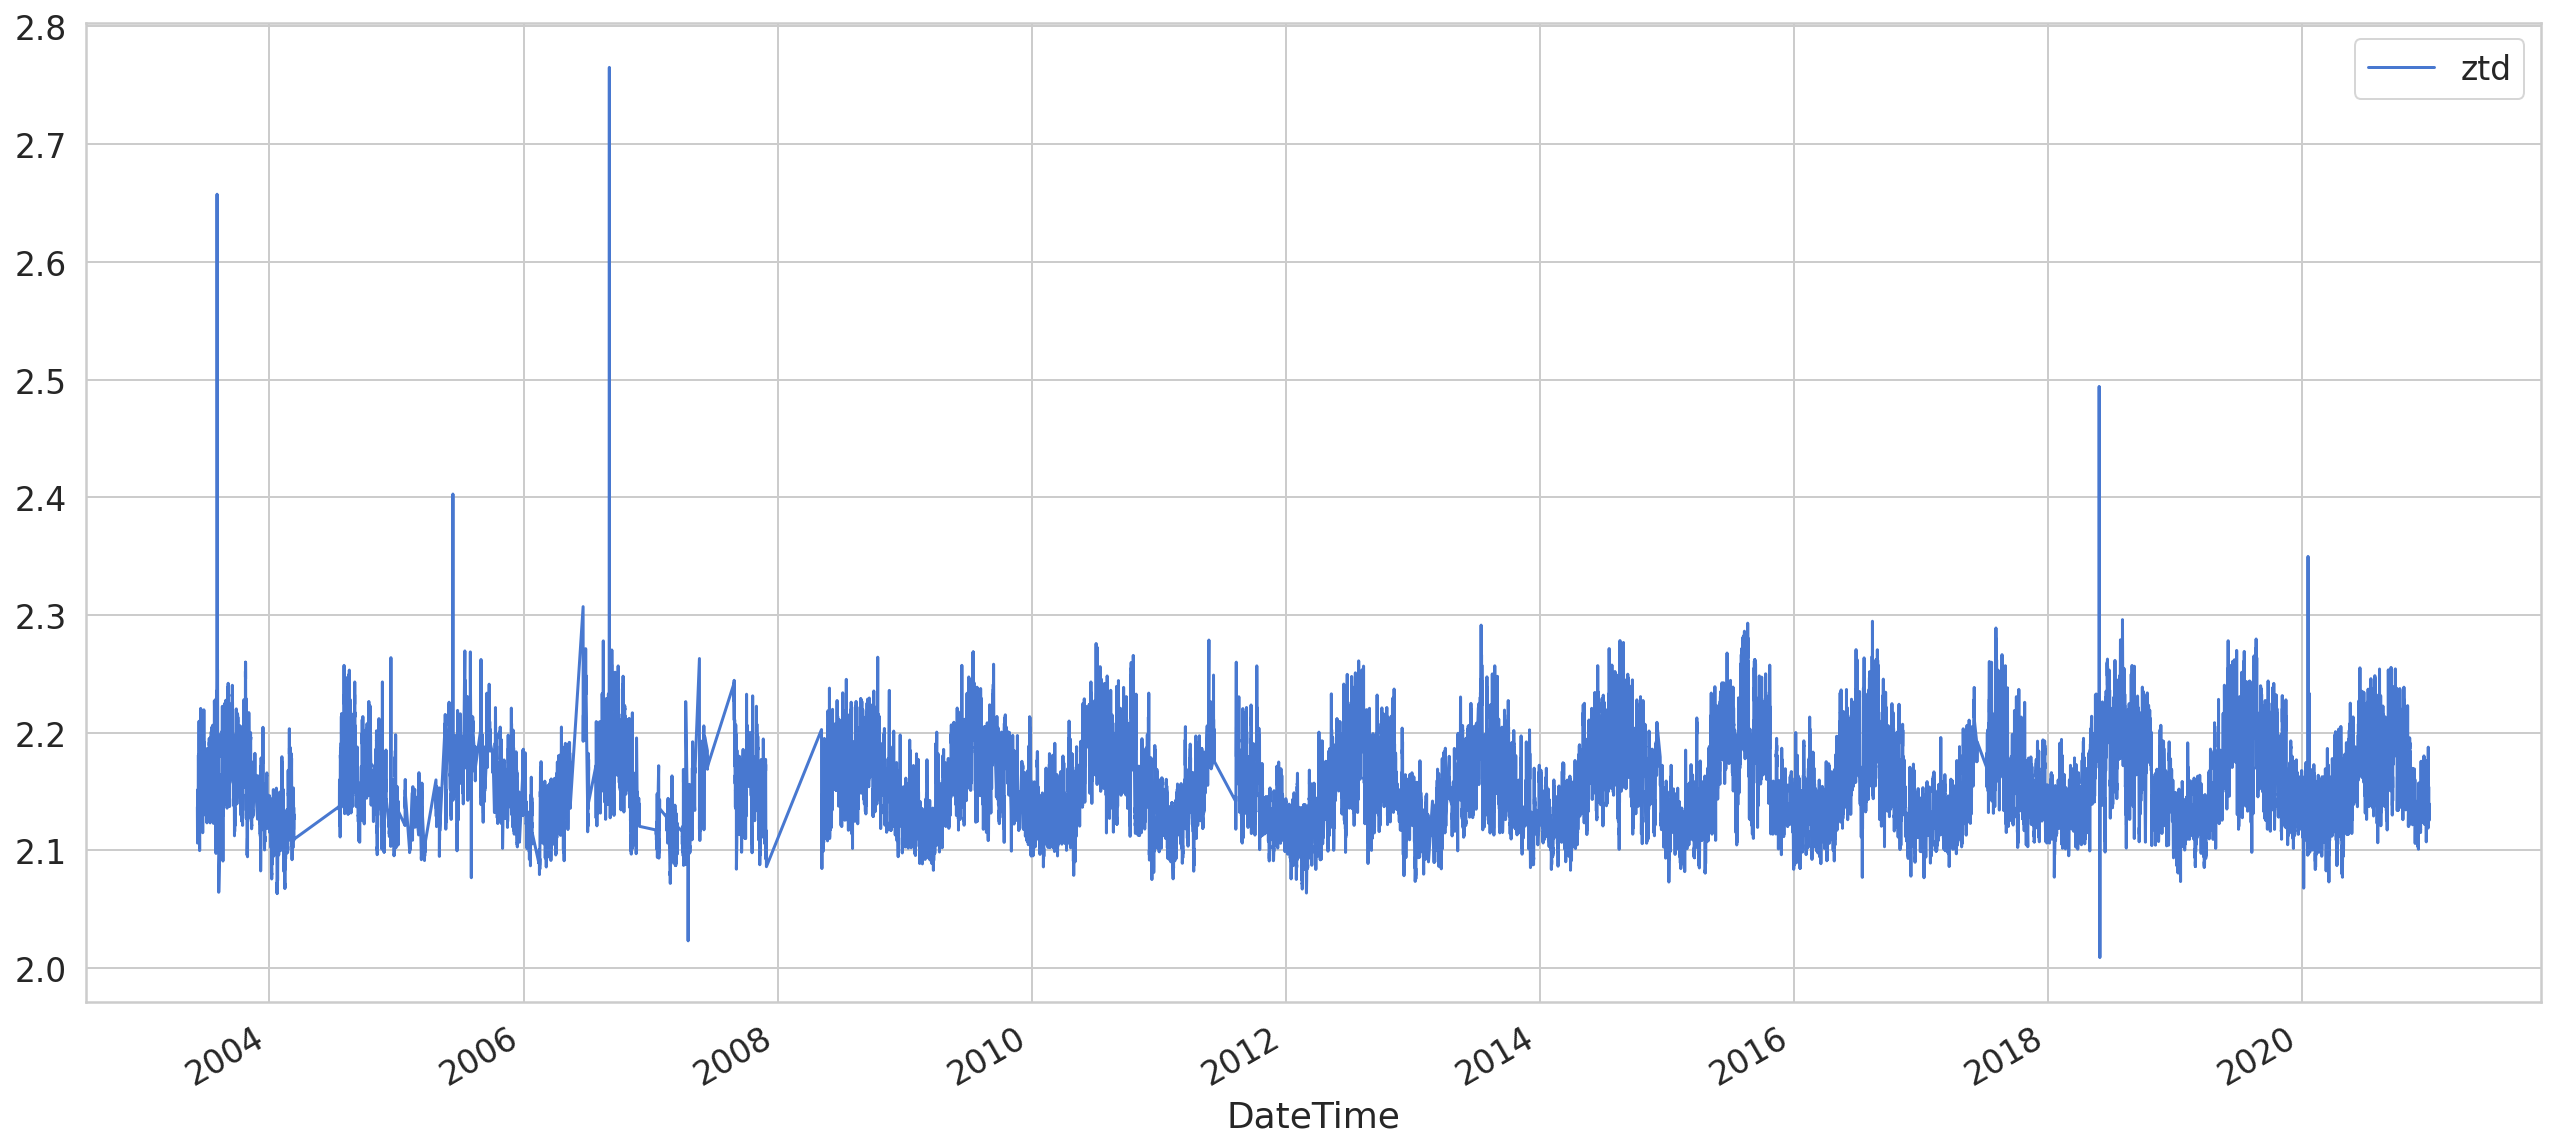

In [40]:
df.plot()

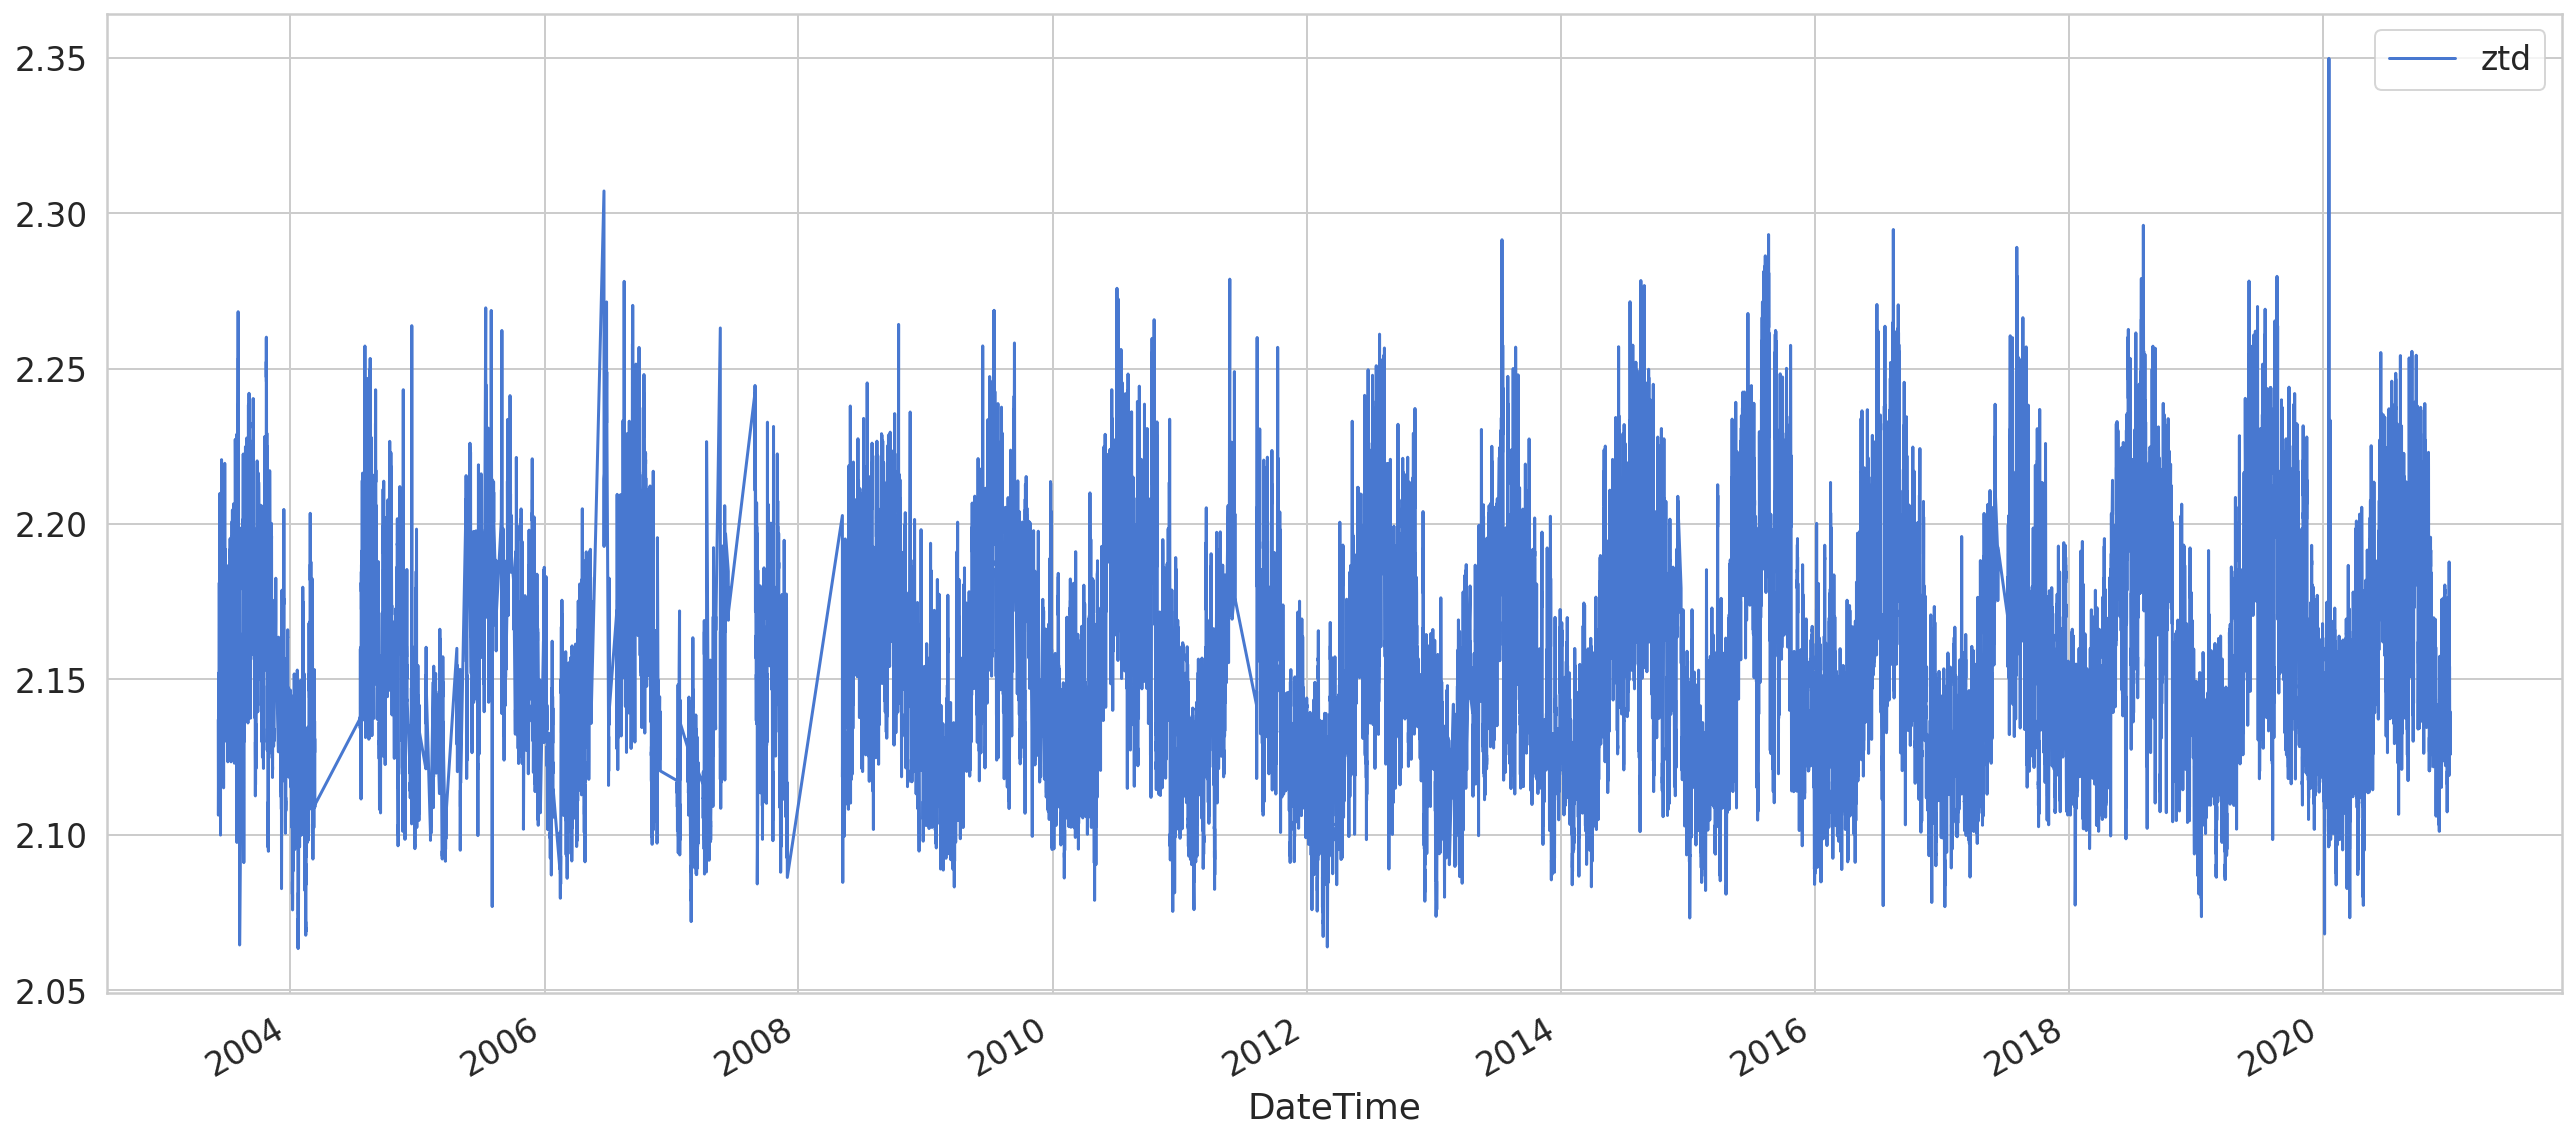

In [41]:
df = df[df.ztd > 2.05]
df = df[df.ztd < 2.35] 
df.plot()

In [42]:
df = df.resample('W').mean()
df = df["2014-01-01":]
df

,ztd
DateTime,
2014-01-05,2.147942
2014-01-12,2.125739
2014-01-19,2.138074
2014-01-26,2.131575
2014-02-02,2.114373
...,...
2020-12-06,2.137459
2020-12-13,2.151161
2020-12-20,2.149631


Checking for null values and replace them with mean.

In [43]:
df["ztd"].isnull().sum()

3

In [44]:
df = df.fillna(df.mean())


In [45]:
df["ztd"].isnull().sum()

0

We can use seasonal decompose to illustrate seasonal effects and trends on our data.

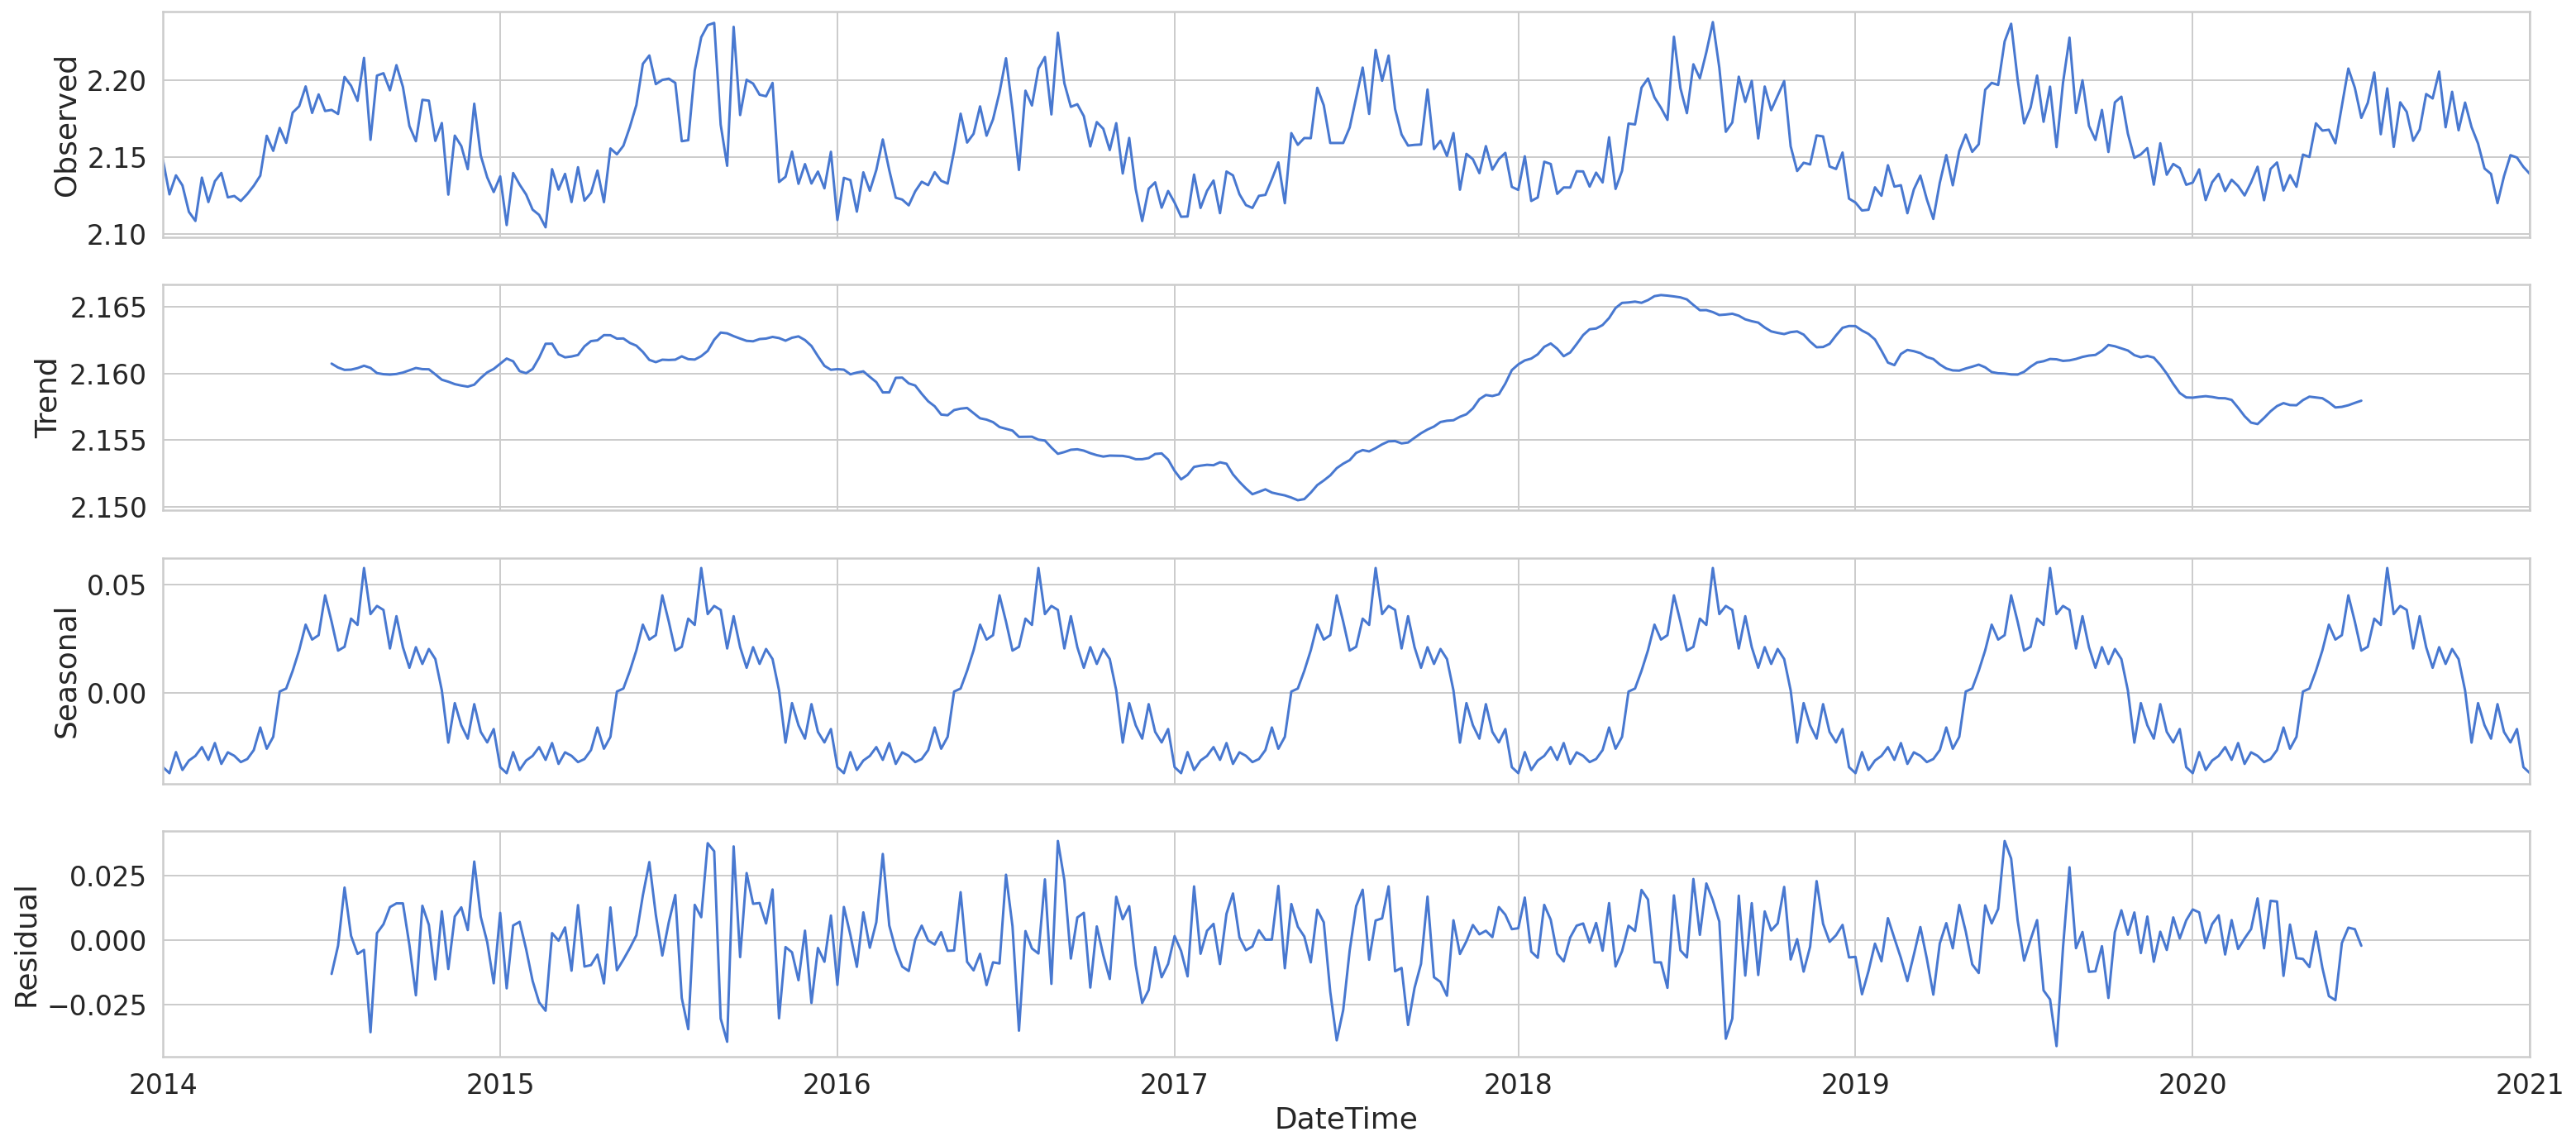

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df["ztd"], model='additive')
result.plot();

In [47]:
len(df)

366

In [48]:
y = df['ztd'].values.astype(float)

test_size = 52
window_size = 52*4    # 4 years

train_set = y[:-test_size]
test_set = y[-test_size:]


scaler = MinMaxScaler(feature_range=(-1, 1))
train_set = scaler.fit_transform(train_set.reshape(-1,1))
test_set = scaler.transform(test_set.reshape(-1,1))

# Run the code below to check your results:
print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')
print(f'Train Shape: {train_set.shape}')
print(f'Test Shape:  {test_set.shape}')

Train: 314
Test:  52
Train Shape: (314, 1)
Test Shape:  (52, 1)


In [49]:
# Run the code below to check your results:
print(f'First item, original: {y[0]}')
print(f'First item, scaled:  {train_set[0]}')

First item, original: 2.1479418681318676
First item, scaled:  [-0.34552632]


In [50]:
train_norm = torch.FloatTensor(train_set).view(-1)

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [51]:
train_data = input_data(train_norm, window_size)
print(f'Train_data: {len(train_data)}')

Train_data: 106


In [52]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]
    
torch.manual_seed(101)
model = LSTMnetwork()
model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [53]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [54]:
epochs = 150
hist = np.zeros(epochs)


for i in range(epochs):
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        # apply the model
        y_pred = model(seq)
        
        # update parameters
        loss = criterion(y_pred, y_train)
        hist[i]=loss.item()
        loss.backward()
        optimizer.step()

    # OPTIONAL print statement
    if i % 5 == 0 and i !=0:
      print("Epoch ", i, "Train Loss: {}".format(loss.item()))

Epoch  5 Train Loss: 0.05785515904426575
Epoch  10 Train Loss: 0.029829269275069237
Epoch  15 Train Loss: 0.0008755546296015382
Epoch  20 Train Loss: 2.2793108655605465e-05
Epoch  25 Train Loss: 0.00121900939848274
Epoch  30 Train Loss: 0.0018131992546841502
Epoch  35 Train Loss: 0.004004945047199726
Epoch  40 Train Loss: 0.00490737846121192
Epoch  45 Train Loss: 0.010021318681538105
Epoch  50 Train Loss: 0.006434471346437931
Epoch  55 Train Loss: 0.007141693029552698
Epoch  60 Train Loss: 0.004632899537682533
Epoch  65 Train Loss: 0.0035039824433624744
Epoch  70 Train Loss: 0.0008973252261057496
Epoch  75 Train Loss: 0.0036107944324612617
Epoch  80 Train Loss: 0.008453520014882088
Epoch  85 Train Loss: 0.0026323371566832066
Epoch  90 Train Loss: 6.652027877862565e-06
Epoch  95 Train Loss: 0.007894082926213741
Epoch  100 Train Loss: 0.0005633297841995955
Epoch  105 Train Loss: 0.001580586889758706
Epoch  110 Train Loss: 0.000445815734565258
Epoch  115 Train Loss: 0.0010470588458701968


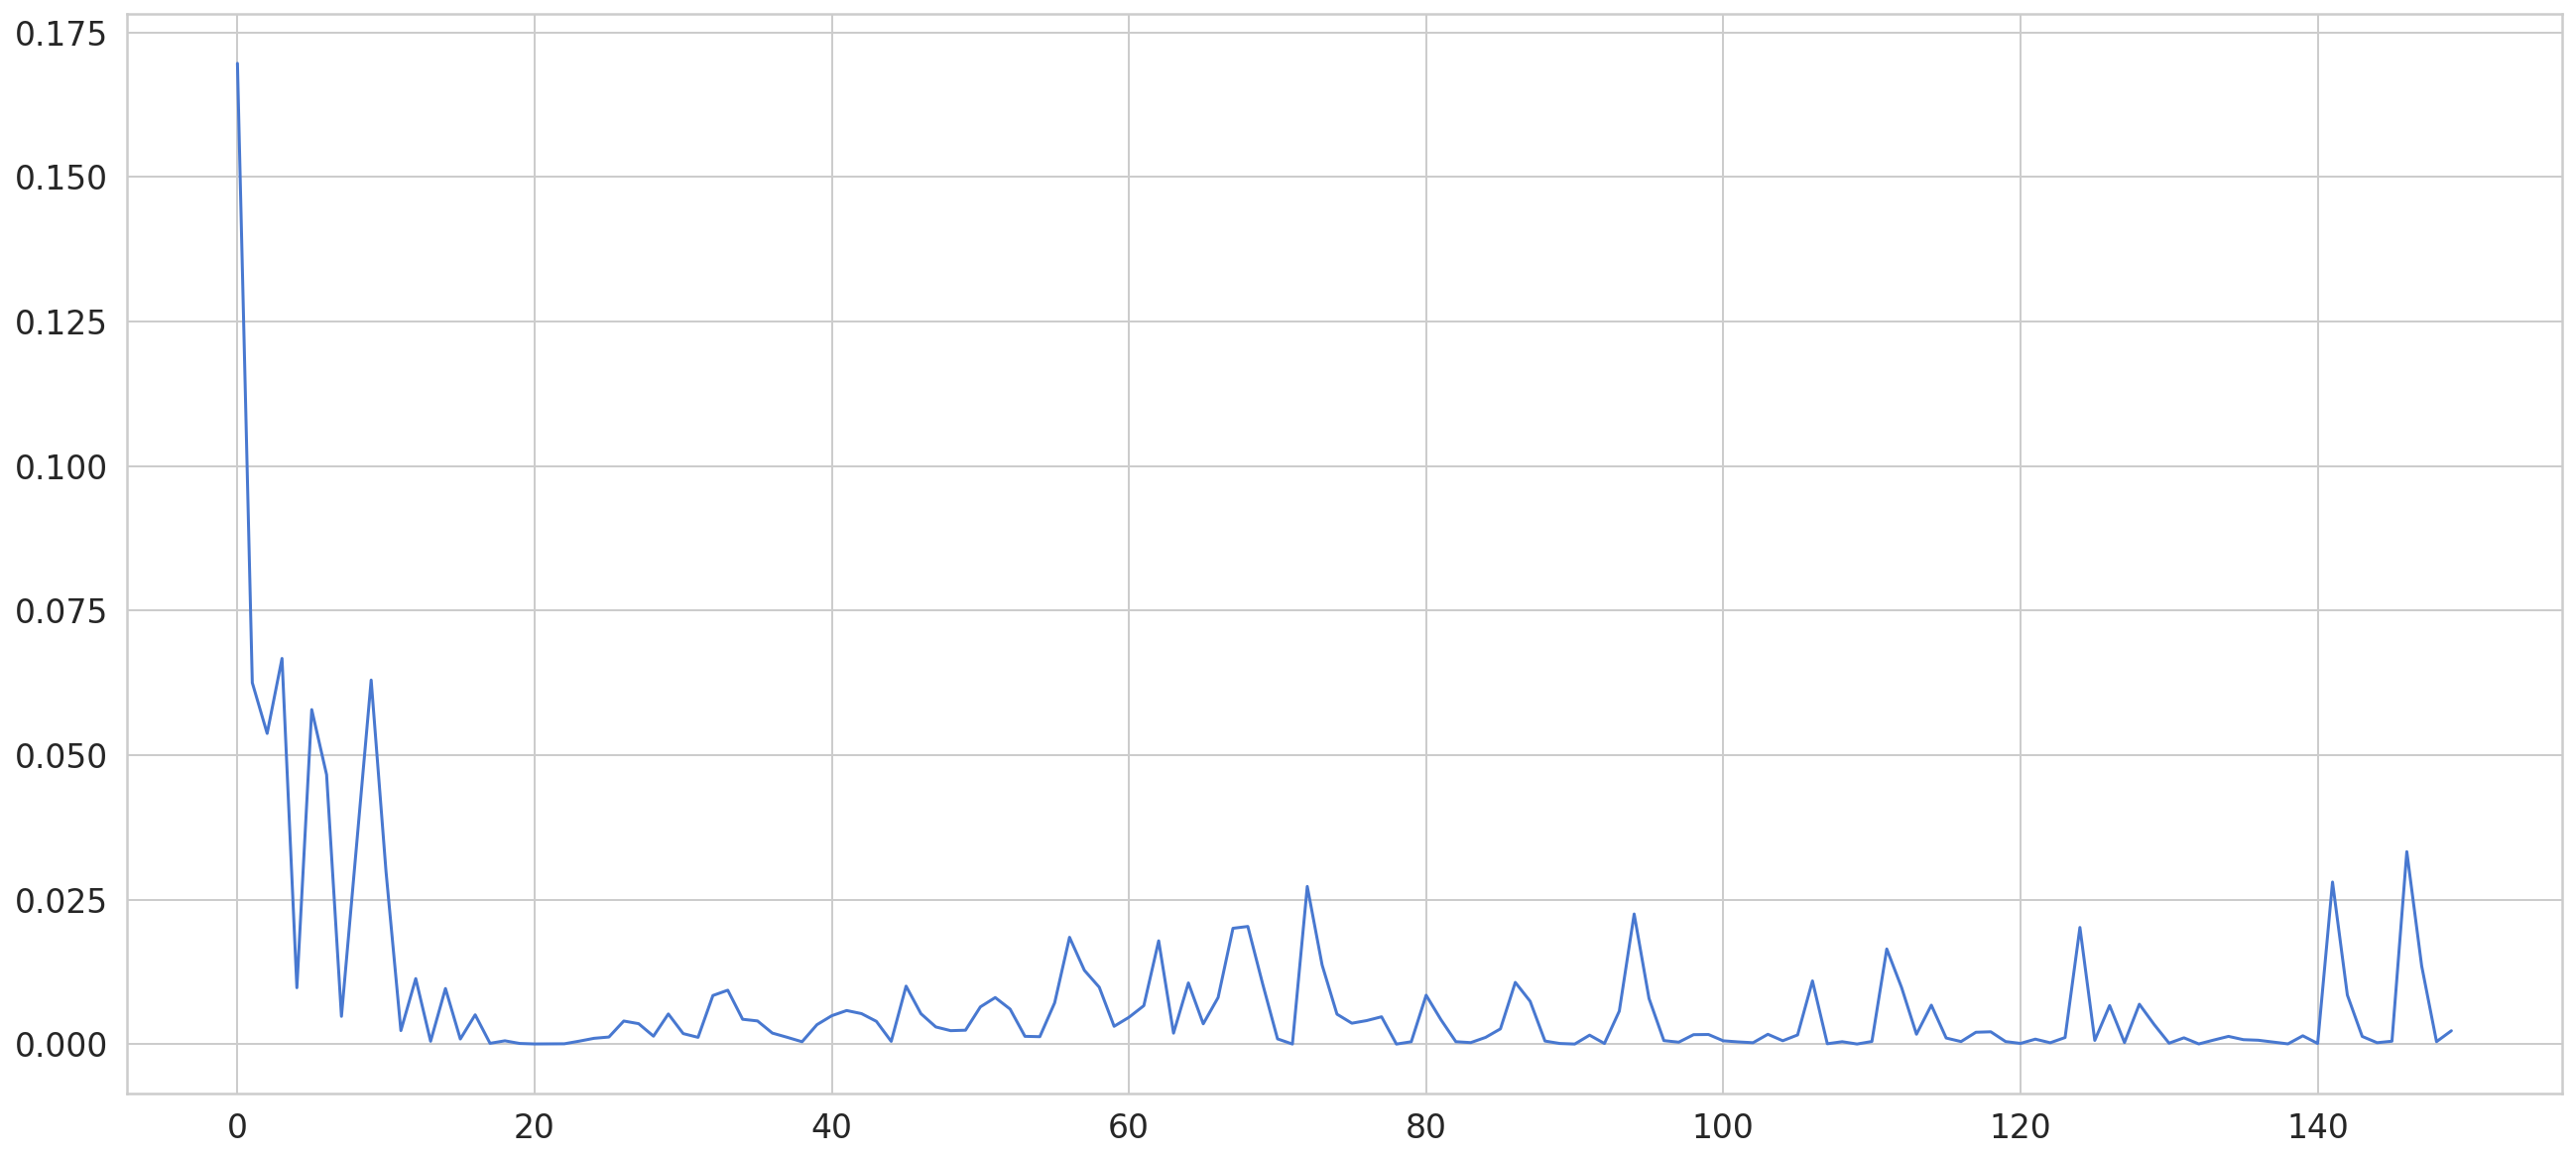

In [55]:
plt.plot(hist)

In [56]:
future = 52
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())
        
preds[window_size:]

[-0.4903011620044708,
 -0.4640290439128876,
 -0.40473034977912903,
 -0.39694318175315857,
 -0.4012072682380676,
 -0.3271772265434265,
 -0.2568722665309906,
 -0.15388593077659607,
 -0.16116341948509216,
 -0.21201860904693604,
 -0.18509617447853088,
 -0.0034520328044891357,
 0.12209858745336533,
 0.32931026816368103,
 0.4607430398464203,
 0.404182106256485,
 0.42395976185798645,
 0.594484806060791,
 0.7276305556297302,
 0.48171916604042053,
 0.49117425084114075,
 0.47956445813179016,
 0.38779568672180176,
 0.2235807478427887,
 0.21603402495384216,
 0.23328399658203125,
 0.2911994457244873,
 0.1754094958305359,
 0.20530718564987183,
 0.1638498604297638,
 0.12939664721488953,
 0.03672478348016739,
 -0.09680233150720596,
 -0.05976773053407669,
 -0.18524792790412903,
 -0.20751449465751648,
 -0.29054614901542664,
 -0.4300944209098816,
 -0.36930233240127563,
 -0.4669462740421295,
 -0.49297383427619934,
 -0.5249276757240295,
 -0.5436570048332214,
 -0.519213080406189,
 -0.5230271220207214,
 -0.4

In [57]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
test_set = scaler.inverse_transform(np.array(test_set.reshape(-1, 1)))

In [58]:
test_data = df[-test_size:]
test_data["Predictions"] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [59]:
test_data.head()

,ztd,Predictions
DateTime,,
2020-01-12,2.141974,2.138298
2020-01-19,2.122029,2.140048
2020-01-26,2.133595,2.143998
2020-02-02,2.139026,2.144517
2020-02-09,2.127878,2.144233


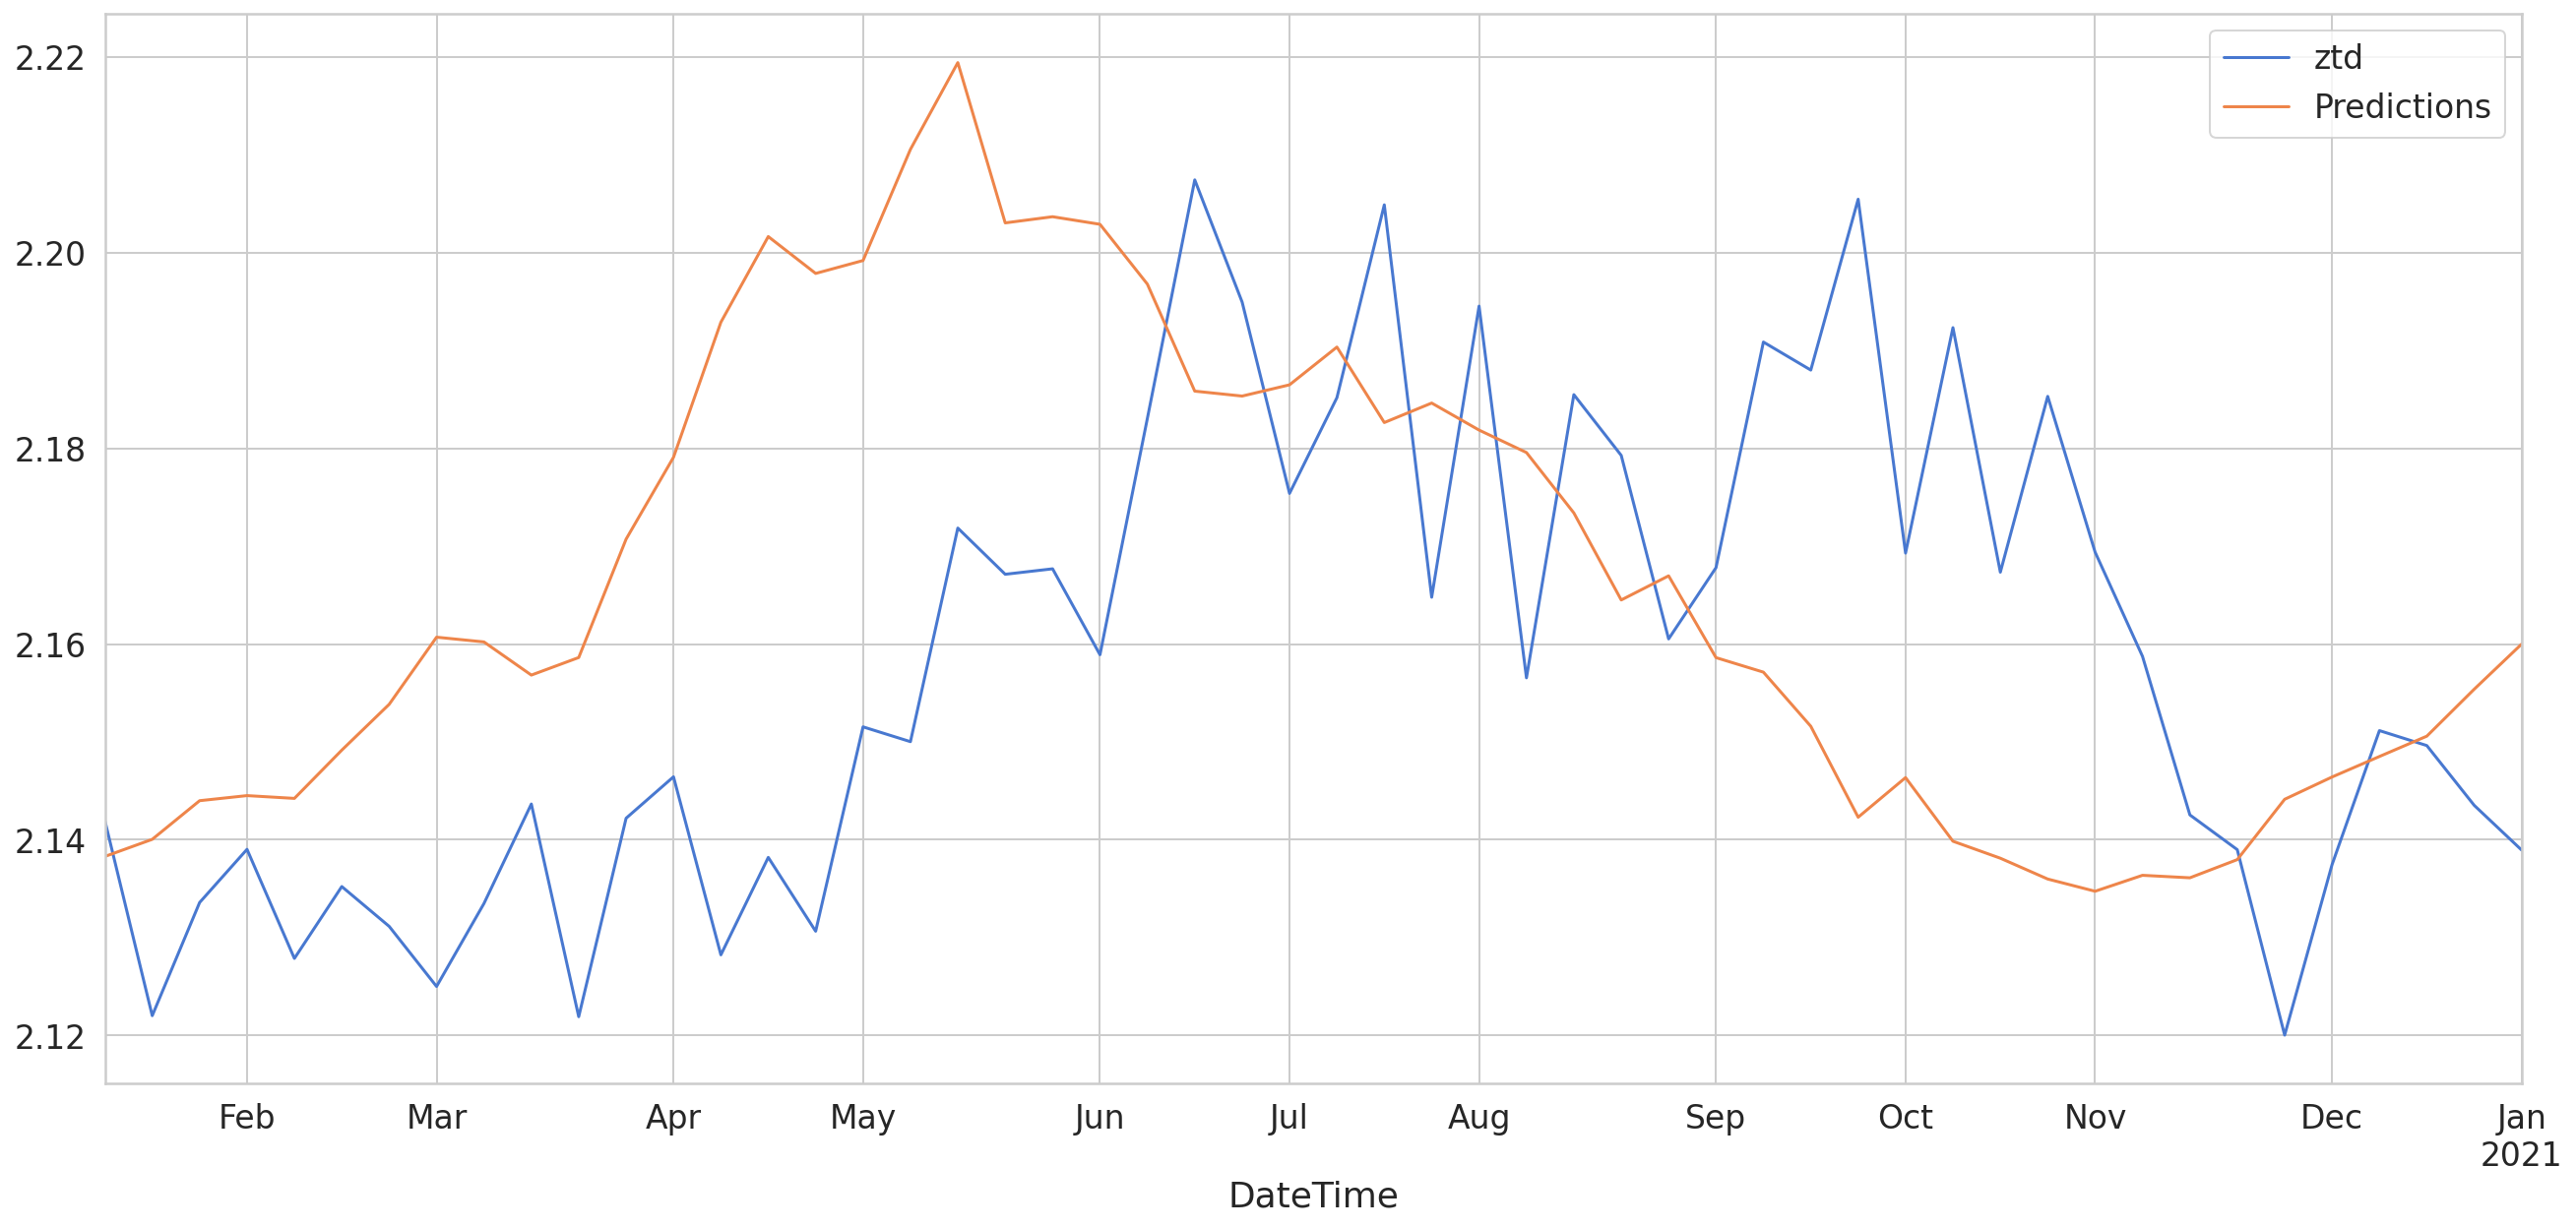

In [60]:
test_data.plot()

In [61]:
mae = mean_squared_error(test_data['ztd'],test_data['Predictions'])
rmse = np.sqrt(mean_squared_error(test_data['ztd'],test_data['Predictions']))
  
print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)

MAE: 0.001
RMSE: 0.031


In [62]:
test_data.mean()

ztd            2.158018
Predictions    2.165967
dtype: float64

In [63]:
test_data.median()

ztd            2.154047
Predictions    2.159314
dtype: float64